In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [11]:
sparsity = dataset.shape[0]/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [13]:
print(sparsity)

0.016439141608663475


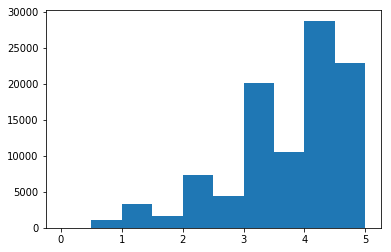

In [19]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [21]:
from collections import Counter
movie_ids = dataset['movieId']
#Counter(movie_ids)

Counter({1: 247,
         2: 107,
         3: 59,
         4: 13,
         5: 56,
         6: 104,
         7: 53,
         8: 5,
         9: 20,
         10: 122,
         11: 82,
         12: 18,
         13: 8,
         14: 31,
         15: 11,
         16: 88,
         17: 86,
         18: 26,
         19: 92,
         20: 13,
         21: 95,
         22: 38,
         23: 22,
         24: 34,
         25: 101,
         26: 5,
         27: 7,
         28: 18,
         29: 40,
         30: 10,
         31: 42,
         32: 196,
         34: 148,
         35: 11,
         36: 104,
         37: 2,
         38: 2,
         39: 120,
         40: 6,
         41: 23,
         42: 9,
         43: 12,
         44: 38,
         45: 43,
         46: 12,
         47: 201,
         48: 61,
         65585: 5,
         50: 201,
         52: 51,
         53: 1,
         54: 3,
         55: 6,
         57: 14,
         58: 45,
         59: 2,
         60: 32,
         61: 7,
         62: 87,
      

In [42]:
movie_ratings_dict = dict(Counter(movie_ids))

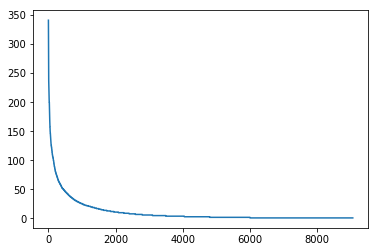

In [43]:
plt.plot(range(0,len(movie_ratings_dict.keys())), sorted(movie_ratings_dict.values(),reverse=True))

In [44]:
user_ids = dataset['userId']

In [45]:
user_ratings_dict = dict(Counter(user_ids))

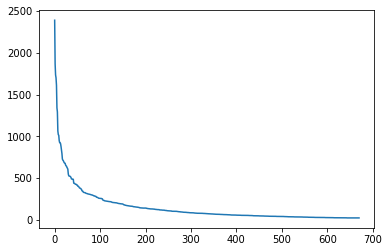

In [46]:
plt.plot(range(0,len(user_ratings_dict.keys())), sorted(user_ratings_dict.values(),reverse=True))

In [49]:
sum(sorted(user_ratings_dict.values(),reverse=True)[:100])

55141

In [67]:
var_list = (dataset[['movieId','rating']].groupby('movieId').var()['rating'])

ValueError: range parameter must be finite.

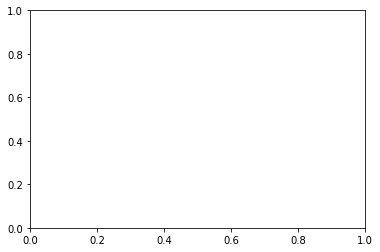

In [68]:
plt.hist(var_list,bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [64]:
type(dataset['rating'])

pandas.core.series.Series